# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO</span>
    - implement 2.a Louvain Clustering 
    - 2.d perform an all-against-all Gene Set Enrichment Analysis (GSEA)

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations

In [1]:
from euclid_knn import knnG
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 22s, sys: 1.86 s, total: 2min 24s
Wall time: 2min 18s


In [3]:
%%time
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].
scanpy.tl.louvain(anndata, resolution=1)

CPU times: user 3.48 s, sys: 53.8 ms, total: 3.53 s
Wall time: 2.97 s


In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

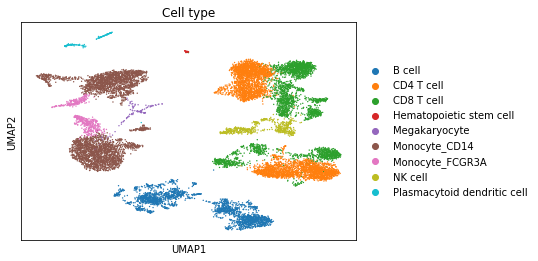

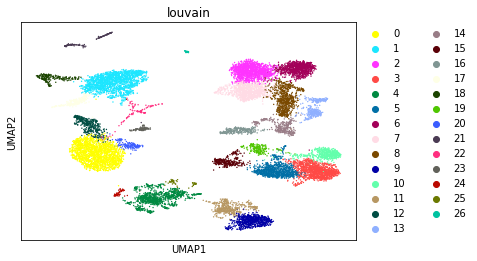

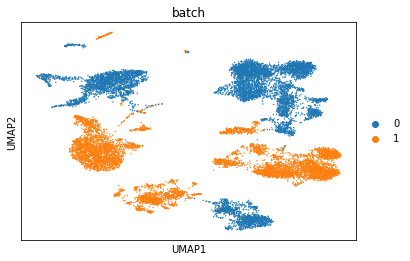

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [6]:
#anndata.obs['louvain'].head(3)

In [7]:
#anndata.obs.loc[:,['louvain', 'Cell type']].head()

In [8]:
df = anndata.obs.loc[:,['louvain', 'Cell type']]
df.head()
grouped = df.groupby(['louvain', 'Cell type'])
# grouped.describe()
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                     7
         Monocyte_CD14                  1867
         Monocyte_FCGR3A                  13
1        Monocyte_CD14                  1699
         Monocyte_FCGR3A                   1
2        CD4 T cell                     1362
         CD8 T cell                       27
3        CD4 T cell                     1223
         CD8 T cell                       40
4        B cell                         1035
         Monocyte_CD14                     2
5        CD4 T cell                      958
         CD8 T cell                        3
6        CD4 T cell                        2
         CD8 T cell                      920
7        CD4 T cell                      884
         CD8 T cell                       11
8        CD4 T cell                       11
         CD8 T cell                      754
         Monocyte_CD14                     1
9        B cell   

## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

### <span style="color:red">aedwip</span>
- def select cells in cluster
- def calc centroid "get signature"

1. create a data frame we can use to select the cells in a given cluster
    a. we need the index value we can use to to get the cell's expression
    values from the numpy array anndata.obsm['X_pca'].shape

In [9]:
numCells = anndata.obs['louvain'].size
numCells

numpyArrayIdx = [i for i in range(numCells)]
d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
louvainDF = pd.DataFrame(data=d)
louvainDF.head()

,louvain,npIdx
index,,
data_3p-AAACCTGAGCATCATC-0,9,0
data_3p-AAACCTGAGCTAGTGG-0,7,1
data_3p-AAACCTGCACATTAGC-0,2,2
data_3p-AAACCTGCACTGTTAG-0,1,3
data_3p-AAACCTGCATAGTAAG-0,1,4


In [10]:
cluster9Cells = louvainDF['louvain'] == '9'
cluster9Cells.head()

index
data_3p-AAACCTGAGCATCATC-0     True
data_3p-AAACCTGAGCTAGTGG-0    False
data_3p-AAACCTGCACATTAGC-0    False
data_3p-AAACCTGCACTGTTAG-0    False
data_3p-AAACCTGCATAGTAAG-0    False
Name: louvain, dtype: bool

In [11]:
louvainDF.loc[cluster9Cells, :].count()

louvain    740
npIdx      740
dtype: int64

In [12]:
louvainDF.loc[cluster9Cells, :].head()

,louvain,npIdx
index,,
data_3p-AAACCTGAGCATCATC-0,9,0
data_3p-AAACGGGCACCTCGGA-0,9,23
data_3p-AAACGGGCAGTAAGAT-0,9,25
data_3p-AAAGATGGTGGTGTAG-0,9,48
data_3p-AAAGATGGTGTGACCC-0,9,49


In [13]:
louvainDF.loc[cluster9Cells, ['npIdx']].head()

,npIdx
index,
data_3p-AAACCTGAGCATCATC-0,0
data_3p-AAACGGGCACCTCGGA-0,23
data_3p-AAACGGGCAGTAAGAT-0,25
data_3p-AAAGATGGTGGTGTAG-0,48
data_3p-AAAGATGGTGTGACCC-0,49


In [14]:
def getCellsIdxForCluster(anndata, clusterId):
    '''
    returns a list of indices that can be use to select the cells in 
    the cluster. the indices are int values that correspond to the
    rows in the numpy array anndata.obsm['X_pca']
    
    assumes clustering algorithym was run and results stored in
    anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    numCells = anndata.obs['louvain'].size

    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterCells = louvainDF['louvain'] == clusterId
    ret = louvainDF.loc[cluster9Cells, ['npIdx']]
    return ret.values.flatten()
    
def testGetCellsIdxForCluster(anndata):
    ret = getCellsIdxForCluster(anndata,clusterId=9)
    assert 753 == len(ret)
    
testGetCellsIdxForCluster(anndata)

AssertionError: 

In [ ]:
# cellIndices = getCellsIdxForCluster(anndata,clusterId=9)
# print(type(cellIndices))
# print(cellIndices.shape)
# print(type(anndata.obsm['X_pca']))
# print(anndata.obsm['X_pca'].shape)
# print(anndata.obsm['X_pca'][cellIndices].shape)
# anndata.obsm['X_pca'][cellIndices]

In [ ]:
def getGeneExpressionSignatureForCluster(anndata, clusterId):
    '''
    returns the centroid for cluster
    
    assumes:
        1) gene expression values stored in anndata.obsm['X_pca']
        
        2) clustering algorithym was run and results stored in
            anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    cellIndices = getCellsIdxForCluster(anndata ,clusterId)
    data = anndata.obsm['X_pca'][cellIndices]

    byColumns = 0
    return np.mean(data, axis=byColumns)

def testGetGeneExpressionSignatureForCluster(anndata):
    ret = getGeneExpressionSignatureForCluster(anndata, clusterId='9')
    expFirst = np.array([-5.547451, 13.029236, -0.9483415, 
                        -5.8531246, -2.0250516])
    expLast = np.array([-0.05719902, -0.16065401, 0.14730875, 
                        0.00936914, -0.06920523])

    np.testing.assert_array_almost_equal(expFirst, ret[0:5])
    np.testing.assert_array_almost_equal(expLast, ret[-5:])
    
testGetGeneExpressionSignatureForCluster(anndata)